### Script for aggregating the results of the giant component (GC) analysis

In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import to_rgba_array
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm

    
sys.path.append("../scripts")
from utils import *
from Europe_utils import *

config = load_config(file='config_unc.json')


# Load data for Belgium

In [2]:
gc_dir = config['paths']['main_output'] / 'belgium_giant_component_all' / 'finished_gc'
assert gc_dir.exists()

In [3]:
def combine_finished_stochastic(finished_folder): #from visualisations_new
    for folder in tqdm(finished_folder.iterdir()):
        if folder.is_dir():
            if not (finished_folder / "aoi_{}.csv".format(folder.stem)).exists():
                files = [f for f in folder.iterdir()]
                df = pd.read_csv(files[0],sep=';')
                for file in files[1:]:
                    df_add = pd.read_csv(file,sep=';')
                    df = pd.concat([df, df_add], sort='False',ignore_index=True)
                df.to_csv(finished_folder / "aoi_{}.csv".format(folder.stem),sep=';')
            else:
                print('already finished for folder {}'.format(folder))

In [6]:
combine_finished_stochastic(gc_dir) #need to do only once

0it [00:00, ?it/s]

already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\finished_gc\1
already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\finished_gc\10
already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\finished_gc\100
already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\finished_gc\110
already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\finished_gc\120
already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\finished_gc\130
already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\finished_gc\140
already finished for folder D:\Europe_percolation\uncertainty_analysis\main_output\belgium_giant_component_all\fin

In [7]:
to_aggregate = []
for file in gc_dir.iterdir():
    if file.is_file():
        if file.suffixes[-1] == '.csv':
            if file.stem != 'reference':
                to_aggregate.append(file)
            else:
                ref_file = file
to_aggregate
ref_file

WindowsPath('D:/Europe_percolation/uncertainty_analysis/main_output/belgium_giant_component_all/finished_gc/reference.csv')

In [8]:
#Process normal result files
df = pd.read_csv(to_aggregate[0],sep=';')
for file in to_aggregate[1:]:
    df_add = pd.read_csv(file,sep=';')
    df = pd.concat([df, df_add], sort='False',ignore_index=True)

df_add = pd.read_csv(ref_file,sep=';')
    
df = df.drop(columns=[col for col in df.columns if col.startswith('Unnamed:')])
df

,AoI combinations,AoI removed,avg extra time,disrupted,edges_in_giant,edges_in_graph,no detour,nodes_in_giant,nodes_in_graph
0,1.0,23751.0,0.000135,0.634249,65591.0,65735.0,0.000000,65735.0,183632.0
1,1.0,22539.0,0.012464,9.196617,65552.0,65710.0,0.000000,65710.0,183632.0
2,1.0,23057.0,0.000000,0.000000,65565.0,65709.0,0.000000,65709.0,183632.0
3,1.0,22814.0,0.000000,0.000000,65589.0,65734.0,0.000000,65734.0,183632.0
4,1.0,22815.0,0.000000,0.000000,65587.0,65732.0,0.000000,65732.0,183632.0
...,...,...,...,...,...,...,...,...,...
56179,90.0,"[22437, 23300, 24060, 23487, 22723, 22035, 229...",0.192572,75.898520,62988.0,63658.0,4.545455,63658.0,183632.0
56180,90.0,"[23398, 23401, 22437, 21822, 23484, 23579, 223...",0.095220,67.230444,63203.0,63781.0,4.545455,63781.0,183632.0
56181,90.0,"[22436, 22314, 23056, 23748, 22544, 25078, 225...",0.249429,76.744186,62633.0,63510.0,0.000000,63510.0,183632.0
56182,90.0,"[24347, 23574, 22814, 22035, 22542, 23295, 234...",0.251520,77.061311,61251.0,62623.0,8.985201,62623.0,183632.0


In [9]:
df.loc[df['AoI combinations']==181.]

,AoI combinations,AoI removed,avg extra time,disrupted,edges_in_giant,edges_in_graph,no detour,nodes_in_giant,nodes_in_graph
20183,181.0,"[22816, 24171, 23661, 22901, 23299, 24959, 221...",0.771130,90.909091,59320.0,61022.0,17.547569,61022.0,183632.0
20184,181.0,"[23576, 23660, 24174, 23486, 22545, 23662, 234...",0.255812,81.289641,59891.0,61540.0,13.319239,61540.0,183632.0
20185,181.0,"[22551, 22114, 22323, 22437, 22115, 24347, 228...",0.397475,88.266385,57447.0,60864.0,25.687104,60864.0,183632.0
20186,181.0,"[25345, 24458, 22720, 24174, 22323, 26021, 218...",0.308345,87.103594,60061.0,61468.0,21.670190,61468.0,183632.0
20187,181.0,"[22217, 22547, 23298, 23483, 22320, 22902, 224...",0.399854,89.534884,59323.0,61034.0,13.319239,61034.0,183632.0
...,...,...,...,...,...,...,...,...,...
22178,181.0,"[23400, 25344, 21931, 22225, 22223, 22111, 238...",0.343508,86.257928,57411.0,60834.0,17.547569,60834.0,183632.0
22179,181.0,"[22905, 22219, 22217, 22434, 22327, 22328, 229...",0.447594,85.412262,60532.0,61812.0,13.319239,61812.0,183632.0
22180,181.0,"[22727, 22114, 22328, 24174, 23484, 21705, 219...",0.371932,88.794926,59534.0,61060.0,21.670190,61060.0,183632.0
22181,181.0,"[25345, 21821, 22436, 23406, 23578, 22320, 233...",0.522228,87.843552,59835.0,61518.0,8.985201,61518.0,183632.0


In [10]:
#Process reference file
reference = pd.read_csv(ref_file,sep=';')
reference = reference.iloc[0]
reference

Unnamed: 0            undisturbed graph
ref_edges_in_graph                65739
ref_nodes_in_graph               183632
ref_edges_in_giant                65595
ref_nodes_in_giant                65739
Name: 0, dtype: object

In [11]:
reference

Unnamed: 0            undisturbed graph
ref_edges_in_graph                65739
ref_nodes_in_graph               183632
ref_edges_in_giant                65595
ref_nodes_in_giant                65739
Name: 0, dtype: object

### Assumption #1: we are only interested in number of edges in the giant (both undisturbed and disturbed)
y-axis: N_disrupted,GC, N_original_GC

x-axis: AoI absoluut / (of relatief)

In [12]:
dfA = df.copy()
dfA['edges_in_giant_%'] = dfA['edges_in_giant'] / reference['ref_edges_in_giant'] * 100
dfA.head()

,AoI combinations,AoI removed,avg extra time,disrupted,edges_in_giant,edges_in_graph,no detour,nodes_in_giant,nodes_in_graph,edges_in_giant_%
0,1.0,23751.0,0.000135,0.634249,65591.0,65735.0,0.0,65735.0,183632.0,99.993902
1,1.0,22539.0,0.012464,9.196617,65552.0,65710.0,0.0,65710.0,183632.0,99.934446
2,1.0,23057.0,0.000000,0.000000,65565.0,65709.0,0.0,65709.0,183632.0,99.954265
3,1.0,22814.0,0.000000,0.000000,65589.0,65734.0,0.0,65734.0,183632.0,99.990853
4,1.0,22815.0,0.000000,0.000000,65587.0,65732.0,0.0,65732.0,183632.0,99.987804


### Make plots

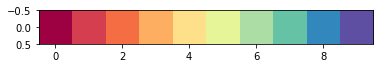

In [13]:
#colorscheme
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']
roads_cc = colors[0:5][::-1] #We iterate over the roads in reversed order
roads_lw_cc = [1,0.7,0.5,.3,.3][::-1] #linewidth cycler
nuts_fill = '#abdda4'
nuts_border = '#66c2a5'

length_cols = ['Total_Edge_Length', 'Len_Motorway', 'Len_Trunk', 'Len_Primary', 'Len_Secondary', 'Len_Tertiary']

road_types = ['motorway','trunk','primary','secondary','tertiary']

plt.imshow(to_rgba_array(colors).reshape(1,len(colors),4))
plt.show()


font = {'family' : 'arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
grey = '#444444'
mpl.rcParams.update({'text.color' : grey,
                     'axes.labelcolor' : grey,
                     'axes.titlecolor' : grey,
                     'axes.edgecolor' : grey,
                     'xtick.color': grey, #This is the color of the categories on y- and x-axis
                     'ytick.color': grey                    })

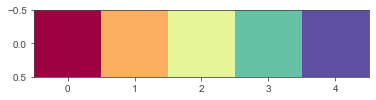

In [14]:
#5 contrasting colors
c = [j for j in colors]
color_5 = [c[0],c[3],c[5],c[7],c[9]]
plt.imshow(to_rgba_array(color_5).reshape(1,len(color_5),4))
plt.show()

Text(0.5, 1.0, 'Belgium')

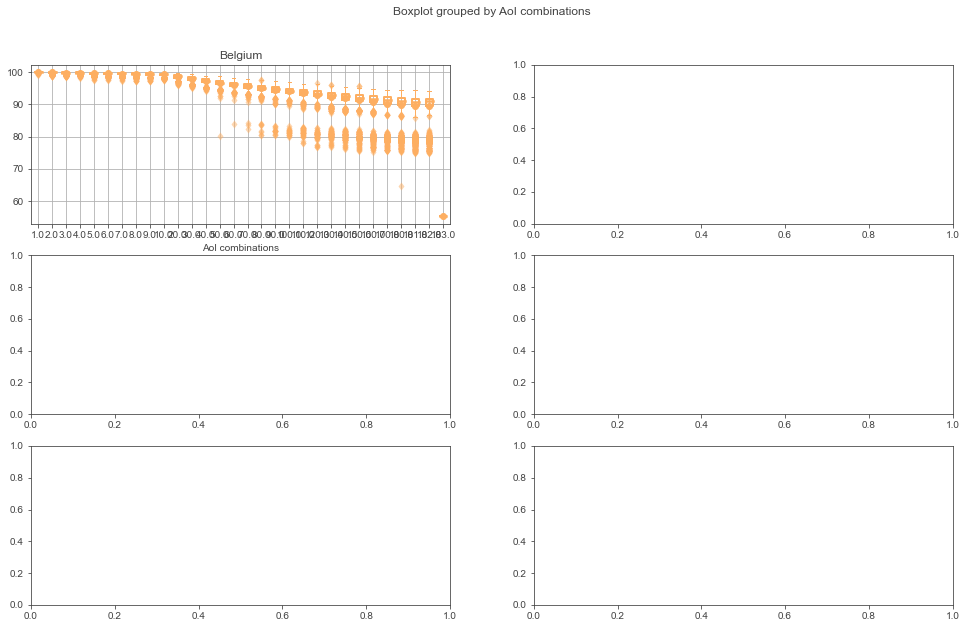

In [15]:
rows = 3
cols = 2
fig,axes = plt.subplots(rows,cols,figsize=(16,10))

Type = 'edges_in_giant_%'


fliermarker = 'd'
meanmarkersize = 6

########### NUTS-3 ################
c = colors[3]
alpha = 0.5


boxprops = dict(linestyle='-', linewidth=2, color=c,alpha=1)
flierprops = dict(marker=fliermarker, markerfacecolor=c, markersize=6,
                  markeredgecolor='none',alpha=alpha)
medianprops = dict(linewidth=2.5, color=c,alpha=1)
meanpointprops = dict(marker='o', markeredgecolor=c,alpha=1, markersize = meanmarkersize,
                      markerfacecolor=c)
capprops = dict(color=c,alpha=1)
whiskerprops = dict(color=c,alpha=1)
#meanlineprops = dict(linestyle='-', linewidth=2.5, color=c)

dfA.boxplot(by='AoI combinations',column=Type,ax=axes[0,0],showmeans=True,
        boxprops=boxprops,flierprops=flierprops,medianprops=medianprops,
        meanprops=meanpointprops,capprops=capprops, whiskerprops=whiskerprops)


handles_S = [
            Line2D([0], [0], color=colors[3], alpha=1,label='NUTS-3 regions (500 repetitions)',linestyle='-'),
            Line2D([0], [0], color=colors[8], alpha=1,label='NUTS-2 regions (500 repetitions)',linestyle='-')]
#axes[0].legend(handles=handles_S) #,labels=labels_S
axes[0,0].set_title('Belgium')

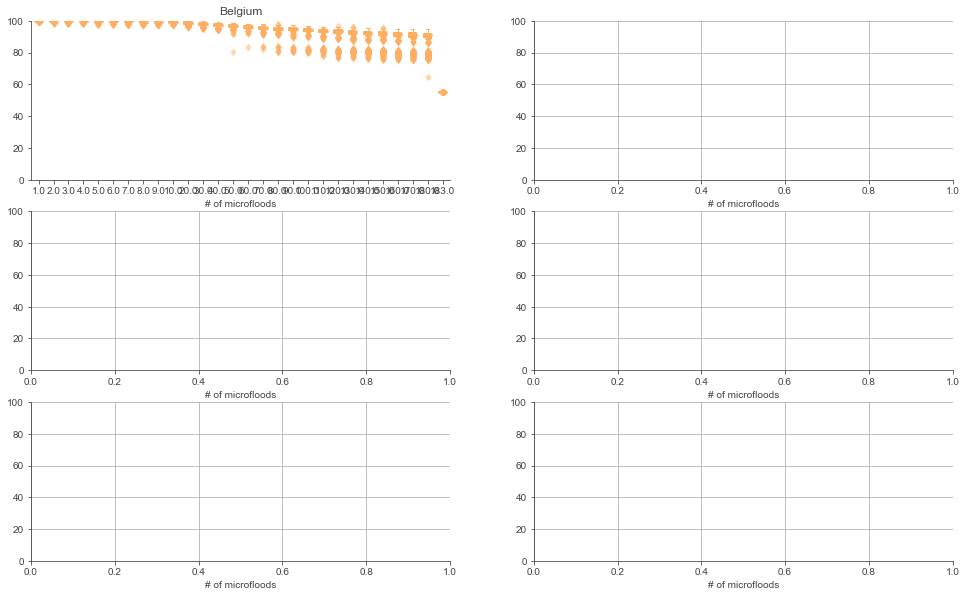

In [27]:
for row in axes:
    for ax in row:
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        #remove labels
        ax.set_ylabel(ylabel=None)
        ax.set_xlabel(xlabel='# of microfloods')
        
        ax.set_ylim(0,100)
        #ax.set_xlim(0,100)
        ax.grid(b=None)
        
        #ax.set_title(label=None)
        
fig.suptitle(t=None)
fig

# Data for Latvia

In [119]:
gc_dir = config['paths']['main_output'] / 'latvia_giant_component' / 'finished_gc'
assert gc_dir.exists()

In [120]:
#combine_finished_stochastic(gc_dir)

In [122]:
to_aggregate = []
for file in gc_dir.iterdir():
    if file.is_file():
        if file.suffixes[-1] == '.csv':
            if file.stem != 'reference':
                to_aggregate.append(file)
            else:
                ref_file = file
#to_aggregate
#ref_file

In [123]:
#Process normal result files
df = pd.read_csv(to_aggregate[0],sep=';')
for file in to_aggregate[1:]:
    df_add = pd.read_csv(file,sep=';')
    df = pd.concat([df, df_add], sort='False',ignore_index=True)

df_add = pd.read_csv(ref_file,sep=';')
    
df = df.drop(columns=[col for col in df.columns if col.startswith('Unnamed:')])
df.head(n=2)

,AoI combinations,AoI removed,avg extra time,disrupted,edges_in_giant,edges_in_graph,no detour,nodes_in_giant,nodes_in_graph
0,1.0,12288.0,0.0,0.0,14051.0,14051.0,0.0,14051.0,28573.0
1,1.0,12289.0,0.0,0.0,14063.0,14063.0,0.0,14063.0,28573.0


In [124]:
#Process reference file
reference = pd.read_csv(ref_file,sep=';')
reference = reference.iloc[0]
reference

Unnamed: 0            undisturbed graph
ref_edges_in_graph                14066
ref_nodes_in_graph                28573
ref_edges_in_giant                14066
ref_nodes_in_giant                14066
Name: 0, dtype: object

In [134]:
dfB = df.copy()
dfB['edges_in_giant_%'] = dfB['edges_in_giant'] / reference['ref_edges_in_giant'] * 100
df['AoI combinations'] = df['AoI combinations'].apply(lambda x: int(x))
dfB.head()

,AoI combinations,AoI removed,avg extra time,disrupted,edges_in_giant,edges_in_graph,no detour,nodes_in_giant,nodes_in_graph,edges_in_giant_%
0,1,12288.0,0.0,0.0,14051.0,14051.0,0.0,14051.0,28573.0,99.893360
1,1,12289.0,0.0,0.0,14063.0,14063.0,0.0,14063.0,28573.0,99.978672
2,1,12338.0,0.0,0.0,14047.0,14050.0,0.0,14050.0,28573.0,99.864923
3,1,12823.0,0.0,0.0,14065.0,14065.0,0.0,14065.0,28573.0,99.992891
4,1,12870.0,0.0,0.0,14065.0,14065.0,0.0,14065.0,28573.0,99.992891


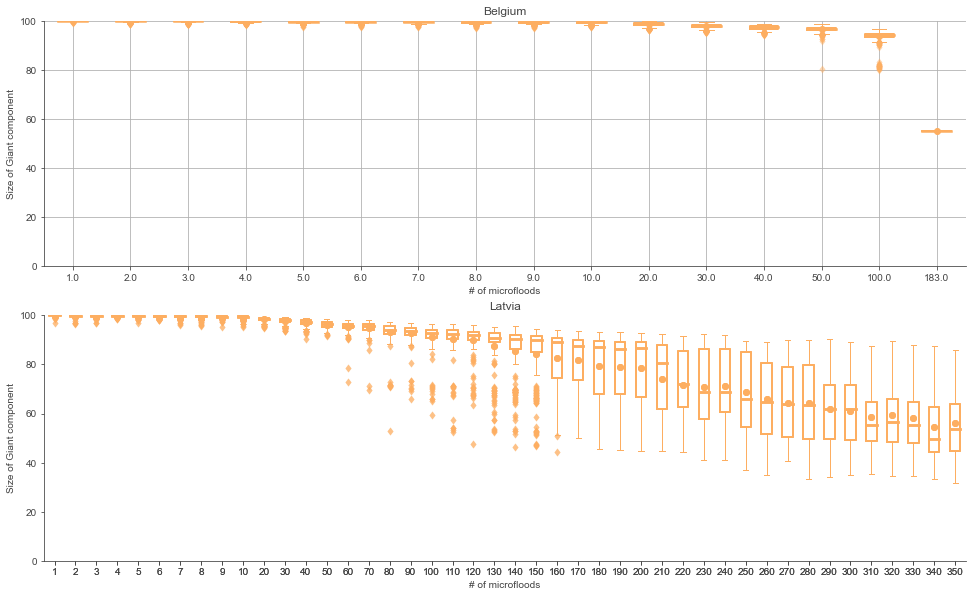

In [138]:
########### NUTS-3 ################
c = colors[3]
alpha = 0.5


boxprops = dict(linestyle='-', linewidth=2, color=c,alpha=1)
flierprops = dict(marker=fliermarker, markerfacecolor=c, markersize=6,
                  markeredgecolor='none',alpha=alpha)
medianprops = dict(linewidth=2.5, color=c,alpha=1)
meanpointprops = dict(marker='o', markeredgecolor=c,alpha=1, markersize = meanmarkersize,
                      markerfacecolor=c)
capprops = dict(color=c,alpha=1)
whiskerprops = dict(color=c,alpha=1)
#meanlineprops = dict(linestyle='-', linewidth=2.5, color=c)

dfB.boxplot(by='AoI combinations',column=Type,ax=axes[1],showmeans=True,
        boxprops=boxprops,flierprops=flierprops,medianprops=medianprops,
        meanprops=meanpointprops,capprops=capprops, whiskerprops=whiskerprops)


handles_S = [
            Line2D([0], [0], color=colors[3], alpha=1,label='NUTS-3 regions (500 repetitions)',linestyle='-'),
            Line2D([0], [0], color=colors[8], alpha=1,label='NUTS-2 regions (500 repetitions)',linestyle='-')]
#axes[0].legend(handles=handles_S) #,labels=labels_S
axes[1].set_title('Latvia')

for ax in axes:
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        #remove labels
        ax.set_ylabel(ylabel='Size of Giant component')
        ax.set_xlabel(xlabel='# of microfloods')
        
        ax.set_ylim(0,100)
        #ax.set_xlim(0,100)
        ax.grid(b=None)
        
fig.suptitle(t=None)

fig